# Image Captioning

Observing that people who are blind have relied on (human-based) image captioning services to learn about images they take for nearly a decade, we introduce the first image captioning dataset to represent this real use case. This new dataset, which we call VizWiz-Captions, consists of 39,181 images originating from people who are blind that are each paired with 5 captions. Our proposed challenge addresses the task of predicting a suitable caption given an image. Ultimately, we hope this work will educate more people about the technological needs of blind people while providing an exciting new opportunity for researchers to develop assistive technologies that eliminate accessibility barriers for blind people (https://vizwiz.org/tasks-and-datasets/image-captioning/).

The goal of this Challenge is to create a single model similar to https://arxiv.org/pdf/1411.4555.pdf to get reasonable results on this task.

In [1]:
#import zipfile
#def extract_zip(filename):
#    with zipfile.ZipFile(filename, 'r') as zip_ref:
#        zip_ref.extractall('./')
#            
#extract_zip('vizwiz_eval_cap.zip')

#!pip3 install torch torchvision torchaudio
#!pip install tensorboard
#!pip install torchtext
#!pip install -U spacy
#!python -m spacy download en_core_web_sm

In [2]:
from vizwiz_api.vizwiz import VizWiz
from vizwiz_eval_cap.eval import VizWizEvalCap
import matplotlib.pyplot as plt
from PIL import Image
import pylab
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models
from torchtext.data import get_tokenizer
from torchtext.vocab import Vocab
from torch.utils.tensorboard import SummaryWriter
from collections import Counter

import json, os, re, time, sys
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [3]:
 def get_alloc_dicts(set_name, vizwiz=None):
    # be sure if `vizwiz` is set, that it contains the `set_name` dataset
    if (set_name != 'train') and (set_name != 'val') and (set_name != 'test'):
        raise Exception('only "train", "val" or "test" is a valid `set_name`')
    
    if not isinstance(vizwiz, VizWiz):
        ann_path = './annotations/'+set_name+'.json'
        vizwiz = VizWiz(ann_path, ignore_rejected=True, ignore_precanned=True)
    
    img_path_prefix = './images/'+set_name+'/'
    img_path_preproc_prefix = './images_preproc/'+set_name+'/'
    img_ids_anns = np.unique([vizwiz.anns[i]['image_id'] for i in vizwiz.anns])
    img_ids_imgs = np.unique([vizwiz.imgs[i]['id'] for i in vizwiz.imgs])
    img_ids_with_capitions = np.array([_id for _id in img_ids_imgs if _id in img_ids_anns])
    imgIdx_enumIdx = {imgIdx:idx for idx, imgIdx in enumerate(img_ids_with_capitions)}
    enumIdx_imgIdx = {idx:imgIdx for idx, imgIdx in enumerate(img_ids_with_capitions)}
    
    imgIdx_imgPath = {vizwiz.imgs[i]['id']:img_path_prefix+vizwiz.imgs[i]['file_name'] for i in vizwiz.imgs if vizwiz.imgs[i]['id'] in img_ids_with_capitions}
    imgIdx_imgPath_preproc = {vizwiz.imgs[i]['id']:img_path_preproc_prefix+vizwiz.imgs[i]['file_name'] for i in vizwiz.imgs if vizwiz.imgs[i]['id'] in img_ids_with_capitions}
    capIdx_imgIdx = {vizwiz.anns[i]['id']:vizwiz.anns[i]['image_id'] for i in vizwiz.anns}
    enumIdx_capIdx = {idx:vizwiz.anns[i]['id'] for idx, i in enumerate(vizwiz.anns)}
    capIdx_cap = {vizwiz.anns[i]['id']:vizwiz.anns[i]['caption'] for i in vizwiz.anns}
    
    def get_img_preproc_path(idx):
        capIdx = enumIdx_capIdx[idx]
        imgIdx = capIdx_imgIdx[capIdx]
        imgPath = imgIdx_imgPath_preproc[imgIdx]
        return imgPath
    
    def get_X_idx(idx):
        capIdx = enumIdx_capIdx[idx]
        imgIdx = capIdx_imgIdx[capIdx]
        X_idx = imgIdx_enumIdx[imgIdx]
        return X_idx
        
    return imgIdx_imgPath, imgIdx_imgPath_preproc, capIdx_imgIdx, enumIdx_capIdx, capIdx_cap, enumIdx_imgIdx, get_img_preproc_path, get_X_idx

In [4]:
ann_train = './annotations/train.json'
vizwiz_train = VizWiz(ann_train, ignore_rejected=True, ignore_precanned=True)
imgIdx_imgPath_train, imgIdx_imgPath_preproc_train, capIdx_imgIdx_train, enumIdx_capIdx_train, \
capIdx_cap_train, enumIdx_imgIdx_train, get_img_preproc_path_train, get_X_idx_train = get_alloc_dicts('train', vizwiz_train)

ann_val = './annotations/val.json'
vizwiz_val = VizWiz(ann_val, ignore_rejected=True, ignore_precanned=True)
imgIdx_imgPath_val, imgIdx_imgPath_preproc_val, capIdx_imgIdx_val, enumIdx_capIdx_val, \
capIdx_cap_val, enumIdx_imgIdx_val, get_img_preproc_path_val, get_X_idx_val = get_alloc_dicts('val', vizwiz_val)

loading annotations into memory...
Done (t=0.34s)
creating index...
index created! imgs = 23431, anns = 100575
loading annotations into memory...
Done (t=0.15s)
creating index...
index created! imgs = 7750, anns = 33145


In [5]:
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

to_pil = transforms.Compose([transforms.ToPILImage()])

In [6]:
def preprocess_imgs(imgIdx_imgPath, imgIdx_imgPath_preproc, preprocess):
    """Preprocesses all images from ./images and stores them in ./images_preproc"""
    if not os.path.isdir('./images_preproc'):
        os.mkdir('./images_preproc')
    if not os.path.isdir('./images_preproc/train'):
        os.mkdir('./images_preproc/train')
    if not os.path.isdir('./images_preproc/val'):
        os.mkdir('./images_preproc/val')
    if not os.path.isdir('./images_preproc/test'):
        os.mkdir('./images_preproc/test')
    
    for i in imgIdx_imgPath:
        img = preprocess(Image.open(imgIdx_imgPath[i]))
        torch.save(img, imgIdx_imgPath_preproc[i])
        
# uncomment if a set is not preprocessed yet
#preprocess_imgs(imgIdx_imgPath_train, imgIdx_imgPath_preproc_train, preprocess)
#preprocess_imgs(imgIdx_imgPath_val, imgIdx_imgPath_preproc_val, preprocess)

In [7]:
def load_imgs(imgIdx_imgPath_preproc):
    """Loads all images in memory for eager loading setup instead of lazy,
    it assumes that `preprocess_imgs` is already done with the set u want to load"""
    imgs = []
    for i in imgIdx_imgPath_preproc:
        img = torch.load(imgIdx_imgPath_preproc[i])
        imgs.append(img)
    imgs = torch.stack(imgs, 0)
    return imgs

caption: ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO.


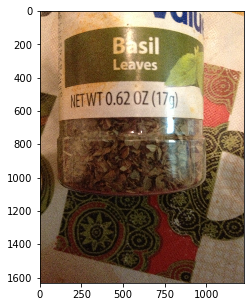

In [8]:
cap1_idx = enumIdx_capIdx_train[0]
cap1 = capIdx_cap_train[cap1_idx]
print('caption:', cap1)
img1_idx = capIdx_imgIdx_train[cap1_idx]
img1 = Image.open(imgIdx_imgPath_train[img1_idx])
_ = plt.figure(figsize=(7,5))
_ = plt.imshow(img1)

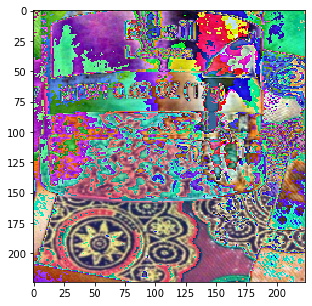

In [9]:
img1_processed = preprocess(img1)
img1_processed_pil = to_pil(img1_processed)
_ = plt.figure(figsize=(7,5))
_ = plt.imshow(img1_processed_pil)

In [10]:
rm_special_chars = lambda s: re.sub(r'[^a-zA-Z0-9 ]', '', s)

def build_vocab(capIdx_cap_train, size=10000):
    size -= 3 # -3 to address specials
    tokenizer = get_tokenizer('basic_english')
    counter = Counter()
    for i in capIdx_cap_train:
        sentence = capIdx_cap_train[i]
        sentence = rm_special_chars(sentence)
        counter.update(tokenizer(sentence.lower()))

    top_tokens = list(dict(counter.most_common(size)).keys())
    drop_tokens = list(set(counter.keys()) - set(top_tokens))
    for drop_token in drop_tokens: # drops all `drop_tokens` from `counter`
        counter.pop(drop_token)

    vocab = Vocab(counter, specials=['<bos>','<eos>','<pad>'])
    
    return tokenizer, vocab

tokenizer, vocab = build_vocab(capIdx_cap_train, size=10000)

In [11]:
def get_sentence_lengths_quantiles(capIdx_cap, tokenizer, vocab):
    lengths = []
    for i in capIdx_cap:
        sentence = capIdx_cap[i]
        sentence = rm_special_chars(sentence)
        sentence_tokenized = [vocab[token] for token in tokenizer(sentence.lower())] # filters the words not included in the vocabulary
        sentence_tokenized = list(filter(None, sentence_tokenized))
        lengths.append(len(sentence_tokenized))
    return np.quantile(lengths, [.5,.75,.9,.95,.99,.995,1])

# uncomment if u wanna show quantiles of the sentence lengths
get_sentence_lengths_quantiles(capIdx_cap_train, tokenizer, vocab)

array([11., 13., 17., 20., 28., 32., 95.])

In [12]:
max_sentence_length = 20

In [13]:
def process_sentences(capIdx_cap, tokenizer, vocab, max_sentence_length):
    y = []
    cap_lengths = []
    for i in capIdx_cap:
        sentence = capIdx_cap[i]
        sentence = rm_special_chars(sentence)
        sentence_tokenized = [vocab[token] for token in tokenizer(sentence.lower())] # tokenizes the sentence and put words not in vocab to None
        sentence_tokenized = list(filter(None, sentence_tokenized))[:max_sentence_length] # filter None (not in vocab) from sentence and slice to max_sentence_length
        cap_length = len(sentence_tokenized)
        cap_lengths.append(cap_length + 2) # +2 is to address '<bos>' and '<eos>'
        max_length_diff = max_sentence_length - cap_length # calculates the numbers of '<pad>' at the start of the sentence
        sentence_tokenized = np.array([vocab['<bos>']]+sentence_tokenized+[vocab['<eos>']]+[vocab['<pad>']]*max_length_diff)
        y.append(sentence_tokenized)
        
    y = np.array(y)
    
    return torch.from_numpy(y), cap_lengths
    
y_train, train_lengths = process_sentences(capIdx_cap_train, tokenizer, vocab, max_sentence_length)
y_val, val_lengths = process_sentences(capIdx_cap_val, tokenizer, vocab, max_sentence_length)

## Model Setup

In [14]:
class ImageCaptioning(Dataset):
    def __init__(self, get_img_fun, preprocess, y, cap_lengths, load_imgs=None, imgIdx_imgPath_preproc=None):
        self.get_img_fun = get_img_fun
        self.get_img_fun_name = get_img_fun.__name__
        self.preprocess = preprocess
        self.y = y.long()
        self.cap_lengths = cap_lengths
        if self.get_img_fun_name == 'get_X_idx':
            self.X = load_imgs(imgIdx_imgPath_preproc)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if self.get_img_fun_name == 'get_img_preproc_path': # lazy loader
            img = torch.load(self.get_img_fun(idx))
        elif self.get_img_fun_name == 'get_X_idx': # eager loader
            img = self.X[self.get_img_fun(idx)]
        cap = self.y[idx]
        cap_length = self.cap_lengths[idx]
        return img, cap, cap_length

In [15]:
data_train = ImageCaptioning(get_img_preproc_path_train, preprocess, y_train, train_lengths)
data_val = ImageCaptioning(get_img_preproc_path_val, preprocess, y_val, val_lengths)

# uncomment if eager instade of lazy img-loading is desired
#data_train = ImageCaptioning(get_X_idx_train, preprocess, y_train, train_lengths, load_imgs, imgIdx_imgPath_preproc_train)
#data_val = ImageCaptioning(get_X_idx_val, preprocess, y_val, val_lengths, load_imgs, imgIdx_imgPath_preproc_val)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [16]:
class ImgCapEncoderCNN(nn.Module):
    """Pretrained ResNet18 with removed last .fc layer"""
    def __init__(self, embedding_dim):
        super(ImgCapEncoderCNN, self).__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1] # deletes the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embedding_dim)
        self.bn = nn.BatchNorm1d(embedding_dim, momentum=0.01)
        
    def forward(self, images):
        with torch.no_grad():
            out = self.resnet(images)
        out = out.reshape(out.size(0), -1)
        out = self.bn(self.linear(out))
        return out

class ImgCapDecoderLSTM(nn.Module):
    """LSTM Decoder with built-in Word Embedding"""
    def __init__(self, embedding_dim, vocab_size, max_sentence_length):
        # embedding_dim=128, vocab_size=10000, max_sentence_length=20
        super(ImgCapDecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.inv_embedding = nn.Linear(embedding_dim, vocab_size)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim)
        
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sentence_length = max_sentence_length + 2 # +2 to cover the added <bos> and <eos>
    
    def forward(self, x, y=None, mode='pred'):
        """`y` is to provide the true label during training"""
        out = []
        hidden = None
        for i in range(self.max_sentence_length):
            output, hidden = self.lstm(x.unsqueeze(0), hidden)
            output = output.squeeze(0)
            y_pred = self.inv_embedding(output)
            if mode == 'pred':
                _, predicted = y_pred.max(1)
                out.append(predicted)
            elif mode == 'train':
                predicted = y[:,i] # takes the true word as input for training
                out.append(y_pred)
            elif mode == 'test':
                _, predicted = y_pred.max(1)
                out.append(y_pred)
            x = self.embedding(predicted)
        out = torch.stack(out, 1)
        return out
    
class ImgCapNet(nn.Module):
    def __init__(self, embedding_dim, vocab_size, max_sentence_length):
        super(ImgCapNet, self).__init__()
        self.ImgCapEncoderCNN = ImgCapEncoderCNN(embedding_dim)
        self.ImgCapDecoderLSTM = ImgCapDecoderLSTM(embedding_dim, vocab_size, max_sentence_length)
        
    def forward(self, x, y=None, cap_lens=None, mode='pred'):
        x1 = self.ImgCapEncoderCNN(x)
        if (mode == 'train') or (mode == 'test'):
            cap_lens, sort_ind = cap_lens.sort(dim=0, descending=True)
            x1 = x1[sort_ind]
            if mode == 'train':
                y = y[sort_ind]
        x2 = self.ImgCapDecoderLSTM(x1, y, mode)
        
        if (mode == 'train') or (mode == 'test'):
            return x2, cap_lens.tolist(), sort_ind
        elif mode == 'pred':
            return x2

In [17]:
def save_iter(json_):
    with open('iter.json', 'w') as fp:
        json.dump(json_, fp)
        
def get_iter():
    path = 'iter.json'
    if os.path.exists(path):
        with open(path, 'r') as fp:
            json_ = json.load(fp)
    else:
        json_ = dict()
    return json_

def get_iter_value(json_, key, model_name):
    if (key not in json_) or (not os.path.exists('./models/'+model_name+'.pth')):
        json_[key] = 0
    return json_[key]

def save_model(model, model_name, iter_json, force=False, test_loss=None):
    """Saves the `model` if `force` is set to True or if `test_loss` is the lowest of `model_name`"""
    path = './models/'+model_name+'.pth'
    if force:
        torch.save(model.state_dict(), path)
    else:
        key = 'test_loss_'+model_name
        if (key not in iter_json) or (not os.path.exists('./models/'+model_name+'.pth')):
            torch.save(model.state_dict(), path)
            iter_json[key] = test_loss
            save_iter(iter_json)
        else:
            best_test_loss = iter_json[key]
            if test_loss < best_test_loss: # stores model only if test_loss is the lowest
                torch.save(model.state_dict(), path)
                iter_json[key] = test_loss
                save_iter(iter_json)
    
def get_model(model, model_num):
    """Loads the stored weights if it exists"""
    path = './models/model_'+str(model_num)+'.pth'
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [18]:
def train_model(model, data_train, data_test, batch_size, lr, n_epochs, model_num, force_save_by_interrupt=True):
    model_name = 'model_'+str(model_num)
    iter_name = 'iter_'+str(model_num)
    iter_name_test = 'iter_test_'+str(model_num)
    iter_name_batch = 'iter_batch_'+str(model_num)
    
    dataloader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    iter_json = get_iter()
    n_iter = get_iter_value(iter_json, iter_name, model_name)
    n_iter_test = get_iter_value(iter_json, iter_name_test, model_name)
    n_iter_batch = get_iter_value(iter_json, iter_name_batch, model_name)
    writer = SummaryWriter('./runs/'+model_name)
    
    try:
        for epoch in range(n_epochs):
            train_loss, test_loss = 0, 0
            # train_loops
            model.train()
            for imgs, caps, caplens in dataloader:
                imgs = imgs.to(device)
                caps = caps.to(device)
                caplens = caplens.to(device)
                
                logits, lengths, sort_ind = model(imgs, y=caps, cap_lens=caplens, mode='train')
                # order logits.view: first_word_first_sentence, first_word_second_sentence, ..., last_word_second_last_sentence, last_word_last_sentence
                #logits = logits.view(logits.shape[0]*logits.shape[1], len(vocab))
                targets = caps[sort_ind]
                # pack_padded_sequence is to not take <pad> into account during training, otherwise the network would learn to add too many <pad> to the output
                scores = pack_padded_sequence(logits, lengths, batch_first=True)[0]
                targets = pack_padded_sequence(targets, lengths, batch_first=True)[0]
                loss = loss_fn(scores, targets)
                
                with torch.no_grad():
                    batch_loss = loss.item()
                    writer.add_scalar('batch_loss', batch_loss, n_iter_batch) # track minibatch_loss
                    n_iter_batch += 1
                    iter_json[iter_name_batch] = n_iter_batch
                    minibatch_ratio = imgs.shape[0] / dataloader.batch_size # correction of contribution of batch_loss to train_loss of the last batch
                    train_loss += batch_loss * minibatch_ratio

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss /= len(dataloader)
            writer.add_scalar('train_loss', train_loss, n_iter)
            n_iter += 1
            iter_json[iter_name] = n_iter
            
            # test_loops
            model.eval()
            with torch.no_grad():
                for imgs, caps, caplens in dataloader_test:
                    imgs = imgs.to(device)
                    caps = caps.to(device)
                    caplens = caplens.to(device)
                    
                    logits, lengths, sort_ind = model(imgs, cap_lens=caplens, mode='test')
                    # order logits.view: first_word_first_sentence, first_word_second_sentence, ..., last_word_second_last_sentence, last_word_last_sentence
                    logits = logits.view(logits.shape[0]*logits.shape[1], len(vocab))
                    targets = caps[sort_ind]
                    # pack_padded_sequence is to not take <pad> into account during training, otherwise the network would learn to add too many <pad> to the output
                    scores = pack_padded_sequence(logits, lengths, batch_first=True)[0]
                    targets = pack_padded_sequence(targets, lengths, batch_first=True)[0]
                    loss = loss_fn(scores, targets)
                    
                    minibatch_ratio = imgs.shape[0] / dataloader_test.batch_size
                    test_loss += loss.item() * minibatch_ratio
                    
                test_loss /= len(dataloader_test)
                writer.add_scalar('test_loss', test_loss, n_iter_test) # uses n_iter_test in case the KeyboardInterrupt occurs during test_loops
                n_iter_test += 1
                iter_json[iter_name_test] = n_iter_test
            
            # stores `iter_json` & `model` after each epoch or a KeyboardInterrupt occured and `store_by_interrupt` is set to True
            print('epoch: '+str(epoch)+'    train_loss: '+str(train_loss)+'    test_loss: '+str(test_loss), end='\r', flush=True)
            save_iter(iter_json)
            save_model(model, model_name, iter_json, force=False, test_loss=test_loss) # model saving only if test_loss < best_test_loss
    except KeyboardInterrupt:
        if force_save_by_interrupt:
            save_iter(iter_json)
            save_model(model, model_name, iter_json, force=True)
            print('\nKeyboardInterrupt, iter_json and model saved')
        else:
            print('\nKeyboardInterrupt, iter_json and model NOT saved')

In [23]:
model_num = 1
icn = ImgCapNet(128, len(vocab), max_sentence_length)
icn = get_model(icn, model_num).to(device) # loads already trained parameters of the model if model_num is available

train_model(model=icn, data_train=data_train, data_test=data_val, batch_size=64, lr=.0001, n_epochs=5, model_num=1, force_save_by_interrupt=True)

torch.Size([64, 22, 10000])
torch.Size([64, 22])
torch.Size([881, 10000])
torch.Size([881])
torch.Size([64, 22, 10000])
torch.Size([64, 22])
torch.Size([890, 10000])
torch.Size([890])
torch.Size([64, 22, 10000])
torch.Size([64, 22])
torch.Size([878, 10000])
torch.Size([878])

KeyboardInterrupt, iter_json and model saved


In [24]:
def eval_img(model, enumIdx_imgIdx, imgIdx_imgPath, imgIdx_imgPath_preproc, vocab, idx):
    get_word = lambda idx: vocab.itos[idx]
    model = model.to('cpu')
    model.eval()
    imgIdx = enumIdx_imgIdx[idx]
    img_pred = torch.load(imgIdx_imgPath_preproc[imgIdx])
    
    pred = model(img_pred.unsqueeze(0))[0]
    pred_sentence = [get_word(word) for word in pred]
    pred_sentence = ' '.join(pred_sentence)
    print(pred_sentence)
    
    img = Image.open(imgIdx_imgPath[imgIdx])
    _ = plt.figure(figsize=(7,5))
    _ = plt.imshow(img)

#eval_img(icn, enumIdx_imgIdx_train, imgIdx_imgPath_train, imgIdx_imgPath_preproc_train, vocab, 411)

26.05.2021: 2h --> Sprechstunde, Challenge & Beschreibung anschauen<br>
28.05.2021: 1h --> Download und Integration der Daten und API<br>
01.06.2021: 5h 30min --> API vertraut machen, Daten laden<br>
02.06.2021: 6h 45min --> Standardisierung der Channels, Laden der Bilder<br>
03.06.2021: 7h 15min --> Erstellen des Vocabulars<br>
04.06.2021: 5h 30min --> Vocabular und Preprocessing von captions fertiggestellt<br>
05.06.2021: 4h --> bugfixing & `get_X_idx` validierung, ImgCapNet \_\_init\_\_ erstellt<br>
06.06.2021: 2h --> update ImgCapNet Architektur<br>
14.06.2021: 8h --> update der Architektur<br>
15.06.2021: 8h --> implementierung des Train-loops und Debugging<br>
16.06.2021: 4h --> änderungen im design vom setup & implementierung des Test-loops<br>
17.06.2021: 2h --> implementierung early stopping über `save_model` & implementierung der Speicherung der preprocessten Bildern<br>
18.06.2021: 6h --> Testen & Verbessern/Verändern des Modells/Preprocessing<br>

Sum: 62h 00min